In [1]:
import os
import numpy as np
import wecgrid 

In [2]:
# Compare timing data between WEC and non-WEC systems
import pandas as pd
import matplotlib.pyplot as plt

def compare_timing_data(time_data_1, time_data_2, label_1="System 1", label_2="System 2"):
    """Compare timing data between two systems."""
    
    print(f"\n{'='*80}")
    print(f"TIMING COMPARISON: {label_1} vs {label_2}")
    print(f"{'='*80}")
    
    # Create comparison DataFrame
    comparison_data = []
    
    # Total simulation time
    total_1 = time_data_1.get('simulation_total', 0)
    total_2 = time_data_2.get('simulation_total', 0)
    
    # Average times for key operations
    avg_pf_1 = np.mean(time_data_1.get('solve_powerflow_times', [0])) * 1000  # Convert to ms
    avg_pf_2 = np.mean(time_data_2.get('solve_powerflow_times', [0])) * 1000
    
    avg_snap_1 = np.mean(time_data_1.get('take_snapshot_times', [0])) * 1000
    avg_snap_2 = np.mean(time_data_2.get('take_snapshot_times', [0])) * 1000
    
    avg_iter_1 = np.mean(time_data_1.get('iteration_times', [0])) * 1000
    avg_iter_2 = np.mean(time_data_2.get('iteration_times', [0])) * 1000
    
    # Print detailed comparison
    print(f"{'Metric':<25} | {label_1:<15} | {label_2:<15} | {'Difference':<15} | {'% Change':<10}")
    print(f"{'-'*25} | {'-'*15} | {'-'*15} | {'-'*15} | {'-'*10}")
    
    # Total simulation time
    diff_total = total_2 - total_1
    pct_total = (diff_total / total_1 * 100) if total_1 > 0 else 0
    print(f"{'Total Simulation (s)':<25} | {total_1:<15.3f} | {total_2:<15.3f} | {diff_total:<15.3f} | {pct_total:<10.1f}%")
    
    # Average power flow time
    diff_pf = avg_pf_2 - avg_pf_1
    pct_pf = (diff_pf / avg_pf_1 * 100) if avg_pf_1 > 0 else 0
    print(f"{'Avg PowerFlow (ms)':<25} | {avg_pf_1:<15.2f} | {avg_pf_2:<15.2f} | {diff_pf:<15.2f} | {pct_pf:<10.1f}%")
    
    # Average snapshot time
    diff_snap = avg_snap_2 - avg_snap_1
    pct_snap = (diff_snap / avg_snap_1 * 100) if avg_snap_1 > 0 else 0
    print(f"{'Avg Snapshot (ms)':<25} | {avg_snap_1:<15.2f} | {avg_snap_2:<15.2f} | {diff_snap:<15.2f} | {pct_snap:<10.1f}%")
    
    # Average iteration time
    diff_iter = avg_iter_2 - avg_iter_1
    pct_iter = (diff_iter / avg_iter_1 * 100) if avg_iter_1 > 0 else 0
    print(f"{'Avg Iteration (ms)':<25} | {avg_iter_1:<15.2f} | {avg_iter_2:<15.2f} | {diff_iter:<15.2f} | {pct_iter:<10.1f}%")
    
    # Number of iterations
    n_iter_1 = len(time_data_1.get('iteration_times', []))
    n_iter_2 = len(time_data_2.get('iteration_times', []))
    print(f"{'Number of Iterations':<25} | {n_iter_1:<15} | {n_iter_2:<15} | {n_iter_2-n_iter_1:<15} | {'-':<10}")
    
    print(f"{'='*80}")
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Timing Comparison: {label_1} vs {label_2}', fontsize=16, fontweight='bold')
    
    # 1. Total simulation time comparison
    systems = [label_1, label_2]
    total_times = [total_1, total_2]
    bars1 = ax1.bar(systems, total_times, color=['skyblue', 'lightcoral'])
    ax1.set_title('Total Simulation Time')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars1, total_times):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}s', ha='center', va='bottom', fontweight='bold')
    
    # 2. Average operation times comparison
    operations = ['PowerFlow', 'Snapshot', 'Iteration']
    times_1 = [avg_pf_1, avg_snap_1, avg_iter_1]
    times_2 = [avg_pf_2, avg_snap_2, avg_iter_2]
    
    x = np.arange(len(operations))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, times_1, width, label=label_1, color='skyblue')
    bars2b = ax2.bar(x + width/2, times_2, width, label=label_2, color='lightcoral')
    
    ax2.set_title('Average Operation Times')
    ax2.set_ylabel('Time (milliseconds)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(operations)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in [bars2a, bars2b]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2, height + 0.1,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 3. Power flow time distribution
    pf_times_1 = np.array(time_data_1.get('solve_powerflow_times', [0])) * 1000
    pf_times_2 = np.array(time_data_2.get('solve_powerflow_times', [0])) * 1000
    
    ax3.hist(pf_times_1, bins=20, alpha=0.7, label=label_1, color='skyblue', density=True)
    ax3.hist(pf_times_2, bins=20, alpha=0.7, label=label_2, color='lightcoral', density=True)
    ax3.set_title('Power Flow Time Distribution')
    ax3.set_xlabel('Time (milliseconds)')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Iteration time series
    iter_times_1 = np.array(time_data_1.get('iteration_times', [0])) * 1000
    iter_times_2 = np.array(time_data_2.get('iteration_times', [0])) * 1000
    
    ax4.plot(range(len(iter_times_1)), iter_times_1, 'o-', label=label_1, color='skyblue', markersize=4)
    ax4.plot(range(len(iter_times_2)), iter_times_2, 's-', label=label_2, color='lightcoral', markersize=4)
    ax4.set_title('Iteration Times Over Simulation')
    ax4.set_xlabel('Iteration Number')
    ax4.set_ylabel('Time (milliseconds)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print(f"\n🔍 KEY INSIGHTS:")
    if pct_total > 5:
        print(f"   • {label_2} takes {pct_total:.1f}% longer overall than {label_1}")
    elif pct_total < -5:
        print(f"   • {label_2} is {abs(pct_total):.1f}% faster overall than {label_1}")
    else:
        print(f"   • Overall simulation times are similar (within 5%)")
    
    if abs(pct_pf) > 5:
        change_dir = "slower" if pct_pf > 0 else "faster"
        print(f"   • {label_2} power flow is {abs(pct_pf):.1f}% {change_dir} than {label_1}")
    
    if abs(pct_snap) > 5:
        change_dir = "slower" if pct_snap > 0 else "faster"
        print(f"   • {label_2} snapshots are {abs(pct_snap):.1f}% {change_dir} than {label_1}")
    
    return {
        'total_time_diff': diff_total,
        'total_time_pct': pct_total,
        'powerflow_diff': diff_pf,
        'powerflow_pct': pct_pf,
        'snapshot_diff': diff_snap,
        'snapshot_pct': pct_snap,
        'iteration_diff': diff_iter,
        'iteration_pct': pct_iter
    }

In [3]:
#### PyPSA - IEEE 14 Bus System benchmark (no WEC)
ieee14_pypsa = wecgrid.Engine()
ieee14_pypsa.case("./grid/IEEE_14_bus.raw")
ieee14_pypsa.load(["pypsa"])
ieee14_pypsa.simulate()
ieee14_pypsa_time = ieee14_pypsa.pypsa.get_timing_data()

# #### PyPSA - IEEE 14 Bus System benchmark (WEC)
ieee14_pypsa_wec = wecgrid.Engine()
ieee14_pypsa_wec.case("./grid/IEEE_14_bus.raw")
ieee14_pypsa_wec.load(["pypsa"])
ieee14_pypsa_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=15, # create a new bus for farm  
   connecting_bus = 1, # Connect to bus 1 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee14_pypsa_wec.simulate()
ieee14_pypsa_wec_time = ieee14_pypsa_wec.pypsa.get_timing_data()

############################################################################

#### PSS/E - IEEE 14 Bus System benchmark (no WEC)
ieee14_psse = wecgrid.Engine()
ieee14_psse.case("./grid/IEEE_14_bus.raw")
ieee14_psse.load(["psse"])
ieee14_psse.simulate()
ieee14_psse_time = ieee14_psse.psse.get_timing_data()

# #### PSS/E - IEEE 14 Bus System benchmark (WEC)
ieee14_psse_wec = wecgrid.Engine()
ieee14_psse_wec.case("./grid/IEEE_14_bus.raw")
ieee14_psse_wec.load(["psse"])
ieee14_psse_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=15, # create a new bus for farm  
   connecting_bus = 1, # Connect to bus 1 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee14_psse_wec.simulate()
ieee14_psse_wec_time = ieee14_psse_wec.psse.get_timing_data()

#####################################################################

comparison_results_pypsa_ieee14 = compare_timing_data(
    ieee14_pypsa_time, 
    ieee14_pypsa_wec_time, 
    "PyPSA: IEEE 14 (No WEC)", 
    "PyPSA: IEEE 14 (With WEC)"
)

comparison_results_psse_ieee14 = compare_timing_data(
    ieee14_psse_time, 
    ieee14_psse_wec_time, 
    "PSS®E: IEEE 14 (No WEC)", 
    "PSS®E: IEEE 14 (With WEC)"
)

comparison_results_both_ieee14 = compare_timing_data(
    ieee14_pypsa_time, 
    ieee14_psse_time, 
    "PyPSA: IEEE 14 (No WEC)", 
    "PSS®E: IEEE 14 (No WEC)"
)

comparison_results_both_wec_ieee14 = compare_timing_data(
    ieee14_pypsa_wec_time, 
    ieee14_psse_wec_time, 
    "PyPSA: IEEE 14 (With WEC)", 
    "PSS®E: IEEE 14 (With WEC)"
)


PyPSA software initialized
PyPSA software initialized
PyPSA software initialized


ImportError: PSS®E not found or not configured correctly.

PyPSA software initialized
PyPSA software initialized
PyPSA software initialized

TIMING COMPARISON: IEEE 24 (No WEC) vs IEEE 24 (With WEC)
Metric                    | IEEE 24 (No WEC) | IEEE 24 (With WEC) | Difference      | % Change  
------------------------- | --------------- | --------------- | --------------- | ----------
Total Simulation (s)      | 27.547          | 27.856          | 0.309           | 1.1       %
Avg PowerFlow (ms)        | 71.53           | 72.03           | 0.51            | 0.7       %
Avg Snapshot (ms)         | 24.12           | 24.66           | 0.54            | 2.2       %
Avg Iteration (ms)        | 95.65           | 96.72           | 1.07            | 1.1       %
Number of Iterations      | 288             | 288             | 0               | -         

TIMING COMPARISON: IEEE 24 (No WEC) vs IEEE 24 (With WEC)
Metric                    | IEEE 24 (No WEC) | IEEE 24 (With WEC) | Difference      | % Change  
------------------------- | --------------- |

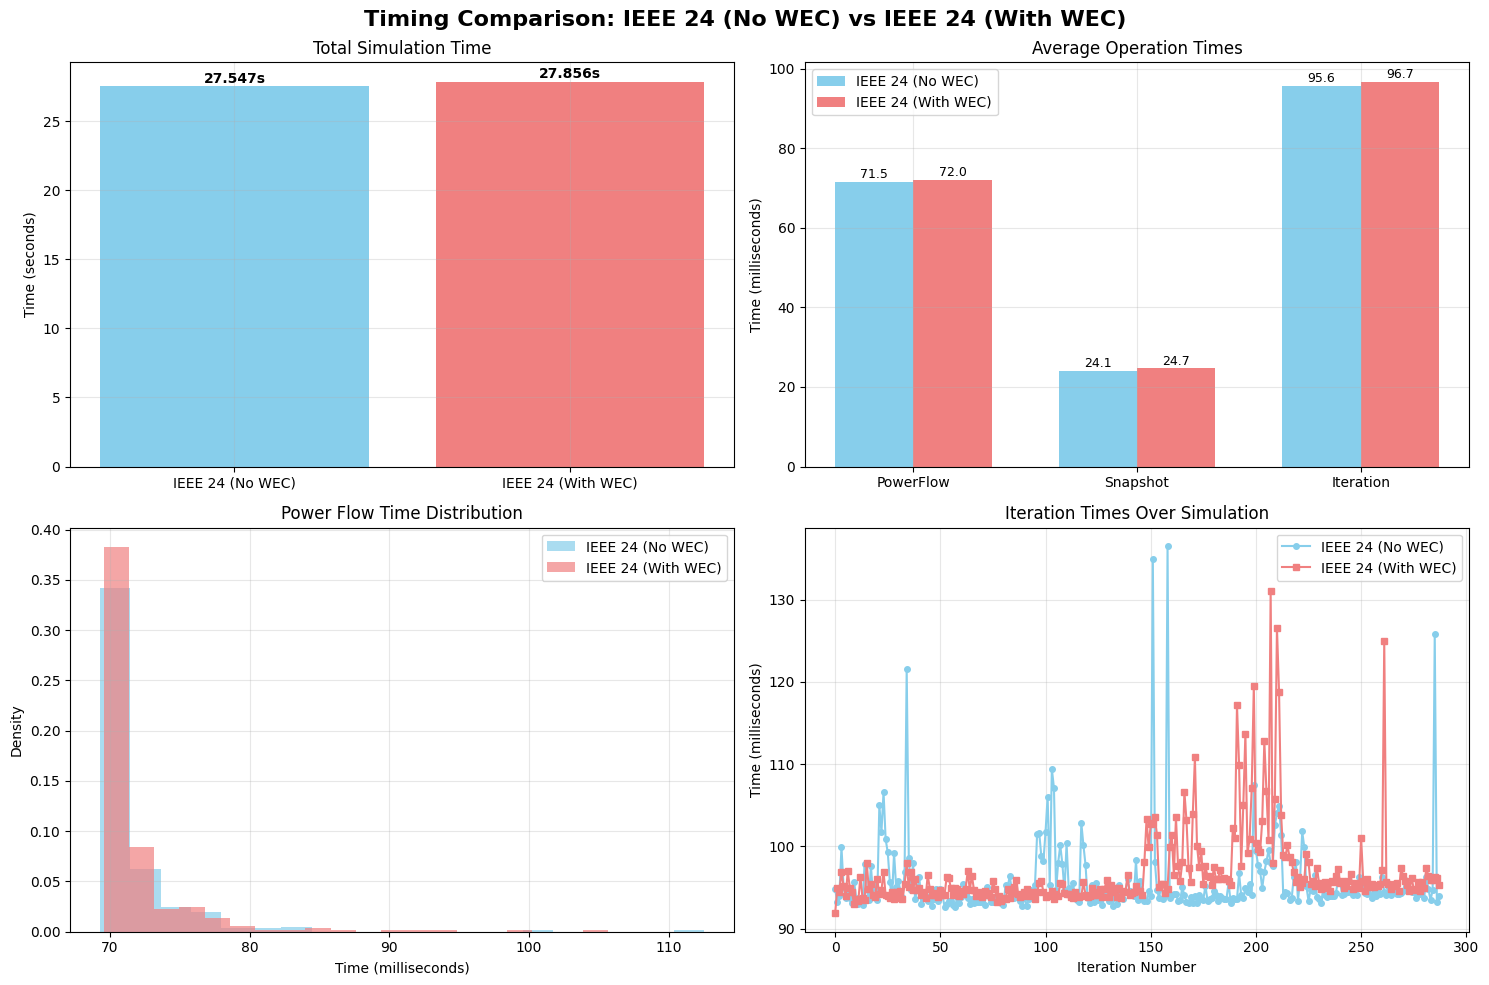


🔍 KEY INSIGHTS:
   • Overall simulation times are similar (within 5%)


In [ ]:
#### PyPSA - IEEE 24 Bus System benchmark (no WEC)
ieee24_pypsa = wecgrid.Engine()
ieee24_pypsa.case("./grid/IEEE_24_bus.raw")
ieee24_pypsa.load(["pypsa"])
ieee24_pypsa.simulate()
ieee24_pypsa_time = ieee24_pypsa.pypsa.get_timing_data()

#### PyPSA - IEEE 24 Bus System benchmark (WEC)
ieee24_pypsa_wec = wecgrid.Engine()
ieee24_pypsa_wec.case("./grid/IEEE_24_bus.raw")
ieee24_pypsa_wec.load(["pypsa"])
ieee24_pypsa_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=25, # create a new bus for farm  
   connecting_bus = 1, # Connect to bus 1 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee24_pypsa_wec.simulate()
ieee24_pypsa_wec_time = ieee24_pypsa_wec.pypsa.get_timing_data()

############################################################################

#### PSS/E - IEEE 24 Bus System benchmark (no WEC)
ieee24_psse = wecgrid.Engine()
ieee24_psse.case("./grid/IEEE_24_bus.raw")
ieee24_psse.load(["psse"])
ieee24_psse.simulate()
ieee24_psse_time = ieee24_psse.psse.get_timing_data()

#### PSS/E - IEEE 24 Bus System benchmark (WEC)
ieee24_psse_wec = wecgrid.Engine()
ieee24_psse_wec.case("./grid/IEEE_24_bus.raw")
ieee24_psse_wec.load(["psse"])
ieee24_psse_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=25, # create a new bus for farm  
   connecting_bus = 1, # Connect to bus 1 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee24_psse_wec.simulate()
ieee24_psse_wec_time = ieee24_psse_wec.psse.get_timing_data()

#####################################################################

comparison_results_pypsa_ieee24 = compare_timing_data(
    ieee24_pypsa_time, 
    ieee24_pypsa_wec_time, 
    "PyPSA: IEEE 24 (No WEC)", 
    "PyPSA: IEEE 24 (With WEC)"
)

comparison_results_psse_ieee24 = compare_timing_data(
    ieee24_psse_time, 
    ieee24_psse_wec_time, 
    "PSS®E: IEEE 24 (No WEC)", 
    "PSS®E: IEEE 24 (With WEC)"
)

comparison_results_both_ieee24 = compare_timing_data(
    ieee24_pypsa_time, 
    ieee24_psse_time, 
    "PyPSA: IEEE 24 (No WEC)", 
    "PSS®E: IEEE 24 (No WEC)"
)

comparison_results_both_wec_ieee24 = compare_timing_data(
    ieee24_pypsa_wec_time, 
    ieee24_psse_wec_time, 
    "PyPSA: IEEE 24 (With WEC)", 
    "PSS®E: IEEE 24 (With WEC)"
)

PyPSA software initialized
PyPSA software initialized
PyPSA software initialized
[PyPSA ERROR]: Failed to add WEC Components: Failed to add Bus component 15 because there is already an object with this name in buses
[PyPSA ERROR]: Failed to add WEC Components: Failed to add Bus component 15 because there is already an object with this name in buses

TIMING COMPARISON: IEEE 30 (No WEC) vs IEEE 30 (With WEC)
Metric                    | IEEE 30 (No WEC) | IEEE 30 (With WEC) | Difference      | % Change  
------------------------- | --------------- | --------------- | --------------- | ----------
Total Simulation (s)      | 27.640          | 28.060          | 0.420           | 1.5       %
Avg PowerFlow (ms)        | 70.04           | 71.14           | 1.10            | 1.6       %
Avg Snapshot (ms)         | 25.93           | 26.25           | 0.32            | 1.2       %
Avg Iteration (ms)        | 95.97           | 97.43           | 1.46            | 1.5       %
Number of Iterations    

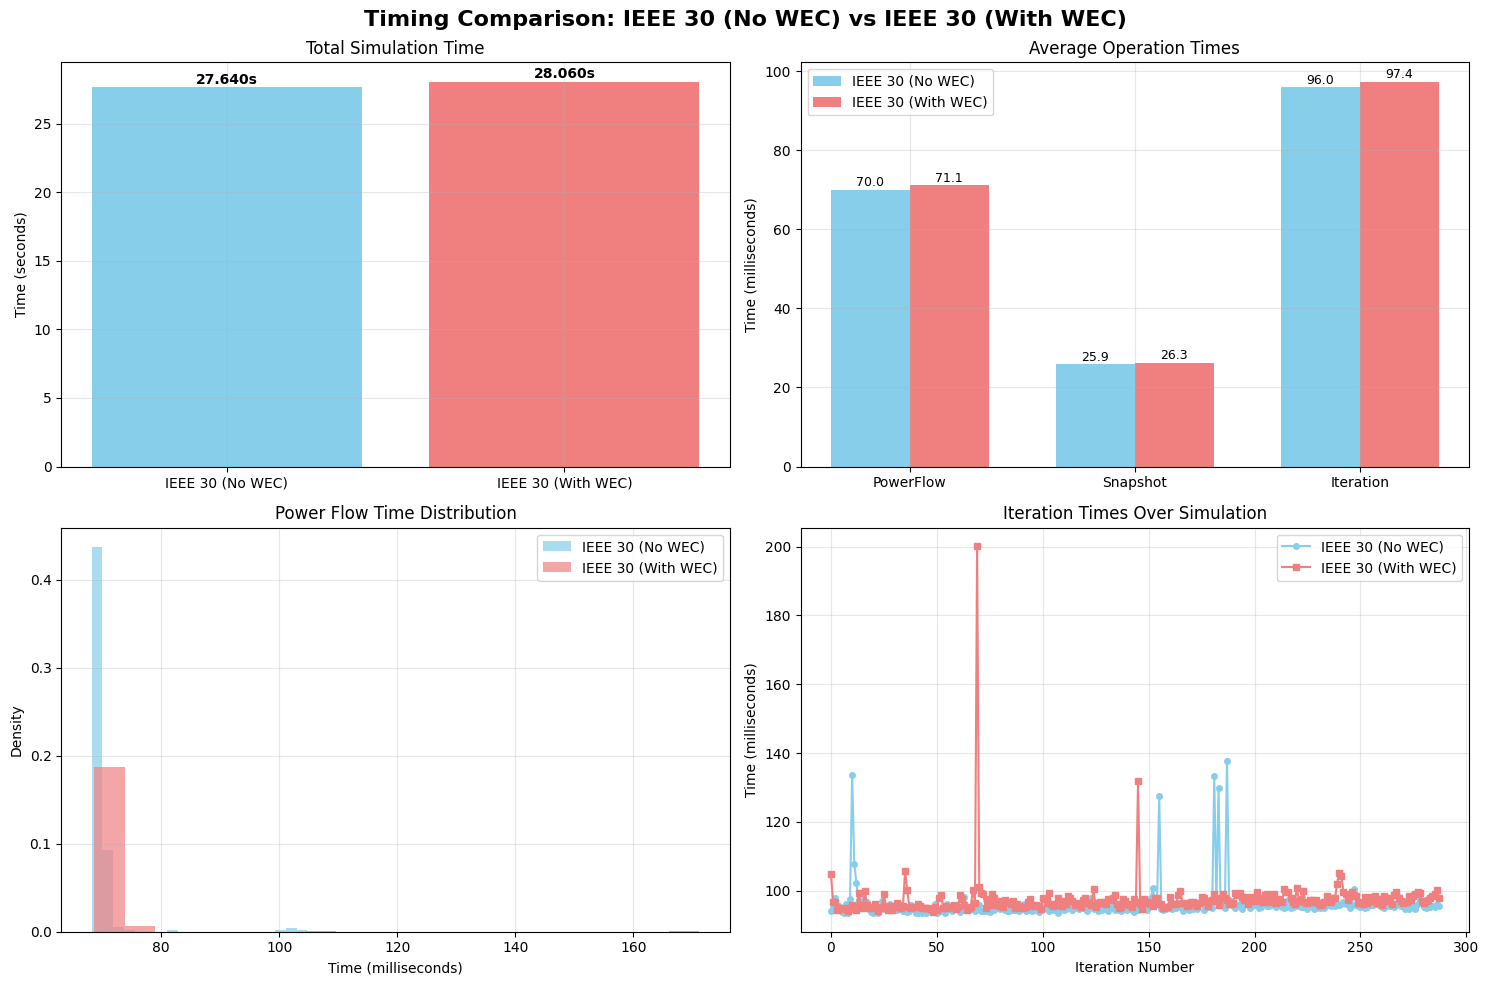


🔍 KEY INSIGHTS:
   • Overall simulation times are similar (within 5%)


In [ ]:
#### PyPSA - IEEE 30 Bus System benchmark (no WEC)
ieee30_pypsa = wecgrid.Engine()
ieee30_pypsa.case("./grid/IEEE_30_bus.raw")
ieee30_pypsa.load(["pypsa"])
ieee30_pypsa.simulate()
ieee30_pypsa_time = ieee30_pypsa.pypsa.get_timing_data()

#### PyPSA - IEEE 30 Bus System benchmark (WEC)
ieee30_pypsa_wec = wecgrid.Engine()
ieee30_pypsa_wec.case("./grid/IEEE_30_bus.raw")
ieee30_pypsa_wec.load(["pypsa"])
ieee30_pypsa_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=31, # create a new bus for farm  
   connecting_bus = 1, # Connect to bus 1 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee30_pypsa_wec.simulate()
ieee30_pypsa_wec_time = ieee30_pypsa_wec.pypsa.get_timing_data()

############################################################################

#### PSS/E - IEEE 30 Bus System benchmark (no WEC)
ieee30_psse = wecgrid.Engine()
ieee30_psse.case("./grid/IEEE_30_bus.raw")
ieee30_psse.load(["psse"])
ieee30_psse.simulate()
ieee30_psse_time = ieee30_psse.psse.get_timing_data()

#### PSS/E - IEEE 30 Bus System benchmark (WEC)
ieee30_psse_wec = wecgrid.Engine()
ieee30_psse_wec.case("./grid/IEEE_30_bus.raw")
ieee30_psse_wec.load(["psse"])
ieee30_psse_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=31, # create a new bus for farm  
   connecting_bus = 1, # Connect to bus 1 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee30_psse_wec.simulate()
ieee30_psse_wec_time = ieee30_psse_wec.psse.get_timing_data()

#####################################################################

comparison_results_pypsa_ieee30 = compare_timing_data(
    ieee30_pypsa_time, 
    ieee30_pypsa_wec_time, 
    "PyPSA: IEEE 30 (No WEC)", 
    "PyPSA: IEEE 30 (With WEC)"
)

comparison_results_psse_ieee30 = compare_timing_data(
    ieee30_psse_time, 
    ieee30_psse_wec_time, 
    "PSS®E: IEEE 30 (No WEC)", 
    "PSS®E: IEEE 30 (With WEC)"
)

comparison_results_both_ieee30 = compare_timing_data(
    ieee30_pypsa_time, 
    ieee30_psse_time, 
    "PyPSA: IEEE 30 (No WEC)", 
    "PSS®E: IEEE 30 (No WEC)"
)

comparison_results_both_wec_ieee30 = compare_timing_data(
    ieee30_pypsa_wec_time, 
    ieee30_psse_wec_time, 
    "PyPSA: IEEE 30 (With WEC)", 
    "PSS®E: IEEE 30 (With WEC)"
)

PyPSA software initialized
PyPSA software initialized
PyPSA software initialized

TIMING COMPARISON: IEEE 39 (No WEC) vs IEEE 39 (With WEC)
Metric                    | IEEE 39 (No WEC) | IEEE 39 (With WEC) | Difference      | % Change  
------------------------- | --------------- | --------------- | --------------- | ----------
Total Simulation (s)      | 30.599          | 29.628          | -0.971          | -3.2      %
Avg PowerFlow (ms)        | 75.22           | 72.17           | -3.05           | -4.0      %
Avg Snapshot (ms)         | 31.02           | 30.67           | -0.35           | -1.1      %
Avg Iteration (ms)        | 106.25          | 102.87          | -3.37           | -3.2      %
Number of Iterations      | 288             | 288             | 0               | -         

TIMING COMPARISON: IEEE 39 (No WEC) vs IEEE 39 (With WEC)
Metric                    | IEEE 39 (No WEC) | IEEE 39 (With WEC) | Difference      | % Change  
------------------------- | --------------- |

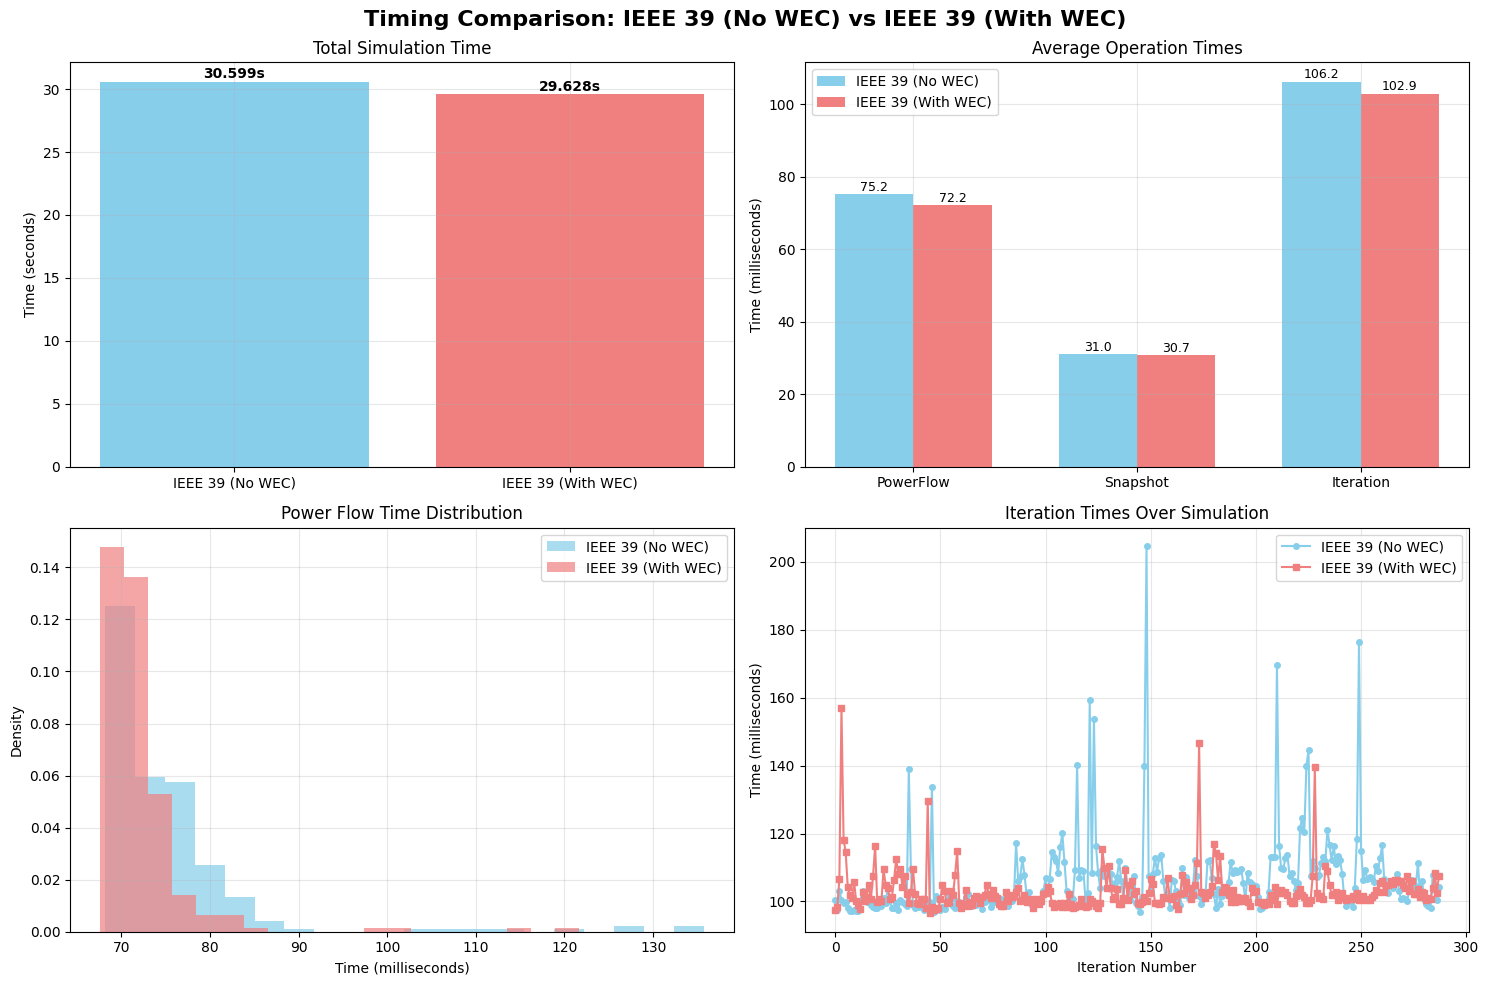


🔍 KEY INSIGHTS:
   • Overall simulation times are similar (within 5%)


In [ ]:
#### PyPSA - IEEE 39 Bus System benchmark (no WEC)
ieee39_pypsa = wecgrid.Engine()
ieee39_pypsa.case("./grid/IEEE_39_bus.raw")
ieee39_pypsa.load(["pypsa"])
ieee39_pypsa.simulate()
ieee39_pypsa_time = ieee39_pypsa.pypsa.get_timing_data()

#### PyPSA - IEEE 39 Bus System benchmark (WEC)
ieee39_pypsa_wec = wecgrid.Engine()
ieee39_pypsa_wec.case("./grid/IEEE_39_bus.raw")
ieee39_pypsa_wec.load(["pypsa"])
ieee39_pypsa_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=40, # create a new bus for farm  
   connecting_bus = 31, # Connect to bus 31 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee39_pypsa_wec.simulate()
ieee39_pypsa_wec_time = ieee39_pypsa_wec.pypsa.get_timing_data()

############################################################################

#### PSS/E - IEEE 39 Bus System benchmark (no WEC)
ieee39_psse = wecgrid.Engine()
ieee39_psse.case("./grid/IEEE_39_bus.raw")
ieee39_psse.load(["psse"])
ieee39_psse.simulate()
ieee39_psse_time = ieee39_psse.psse.get_timing_data()

#### PSS/E - IEEE 39 Bus System benchmark (WEC)
ieee39_psse_wec = wecgrid.Engine()
ieee39_psse_wec.case("./grid/IEEE_39_bus.raw")
ieee39_psse_wec.load(["psse"])
ieee39_psse_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=40, # create a new bus for farm  
   connecting_bus = 31, # Connect to bus 31 or swing bus
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee39_psse_wec.simulate()
ieee39_psse_wec_time = ieee39_psse_wec.psse.get_timing_data()

#####################################################################

comparison_results_pypsa_ieee39 = compare_timing_data(
    ieee39_pypsa_time, 
    ieee39_pypsa_wec_time, 
    "PyPSA: IEEE 39 (No WEC)", 
    "PyPSA: IEEE 39 (With WEC)"
)

comparison_results_psse_ieee39 = compare_timing_data(
    ieee39_psse_time, 
    ieee39_psse_wec_time, 
    "PSS®E: IEEE 39 (No WEC)", 
    "PSS®E: IEEE 39 (With WEC)"
)

comparison_results_both_ieee39 = compare_timing_data(
    ieee39_pypsa_time, 
    ieee39_psse_time, 
    "PyPSA: IEEE 39 (No WEC)", 
    "PSS®E: IEEE 39 (No WEC)"
)

comparison_results_both_wec_ieee39 = compare_timing_data(
    ieee39_pypsa_wec_time, 
    ieee39_psse_wec_time, 
    "PyPSA: IEEE 39 (With WEC)", 
    "PSS®E: IEEE 39 (With WEC)"
)

/Users/alex_barajas/paper_revision/WEC-Grid/src/wecgrid/modelers/power_system/base.py:341: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tdf[col] = pd.NA


PyPSA software initialized


/Users/alex_barajas/paper_revision/WEC-Grid/src/wecgrid/modelers/power_system/base.py:341: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tdf[col] = pd.NA


PyPSA software initialized

TIMING COMPARISON: IEEE 96 (No WEC) vs IEEE 96 (With WEC)
Metric                    | IEEE 96 (No WEC) | IEEE 96 (With WEC) | Difference      | % Change  
------------------------- | --------------- | --------------- | --------------- | ----------
Total Simulation (s)      | 40.342          | 41.433          | 1.092           | 2.7       %
Avg PowerFlow (ms)        | 80.73           | 82.49           | 1.77            | 2.2       %
Avg Snapshot (ms)         | 59.34           | 61.33           | 1.99            | 3.4       %
Avg Iteration (ms)        | 140.07          | 143.86          | 3.79            | 2.7       %
Number of Iterations      | 288             | 288             | 0               | -         

TIMING COMPARISON: IEEE 96 (No WEC) vs IEEE 96 (With WEC)
Metric                    | IEEE 96 (No WEC) | IEEE 96 (With WEC) | Difference      | % Change  
------------------------- | --------------- | --------------- | --------------- | ----------
Total 

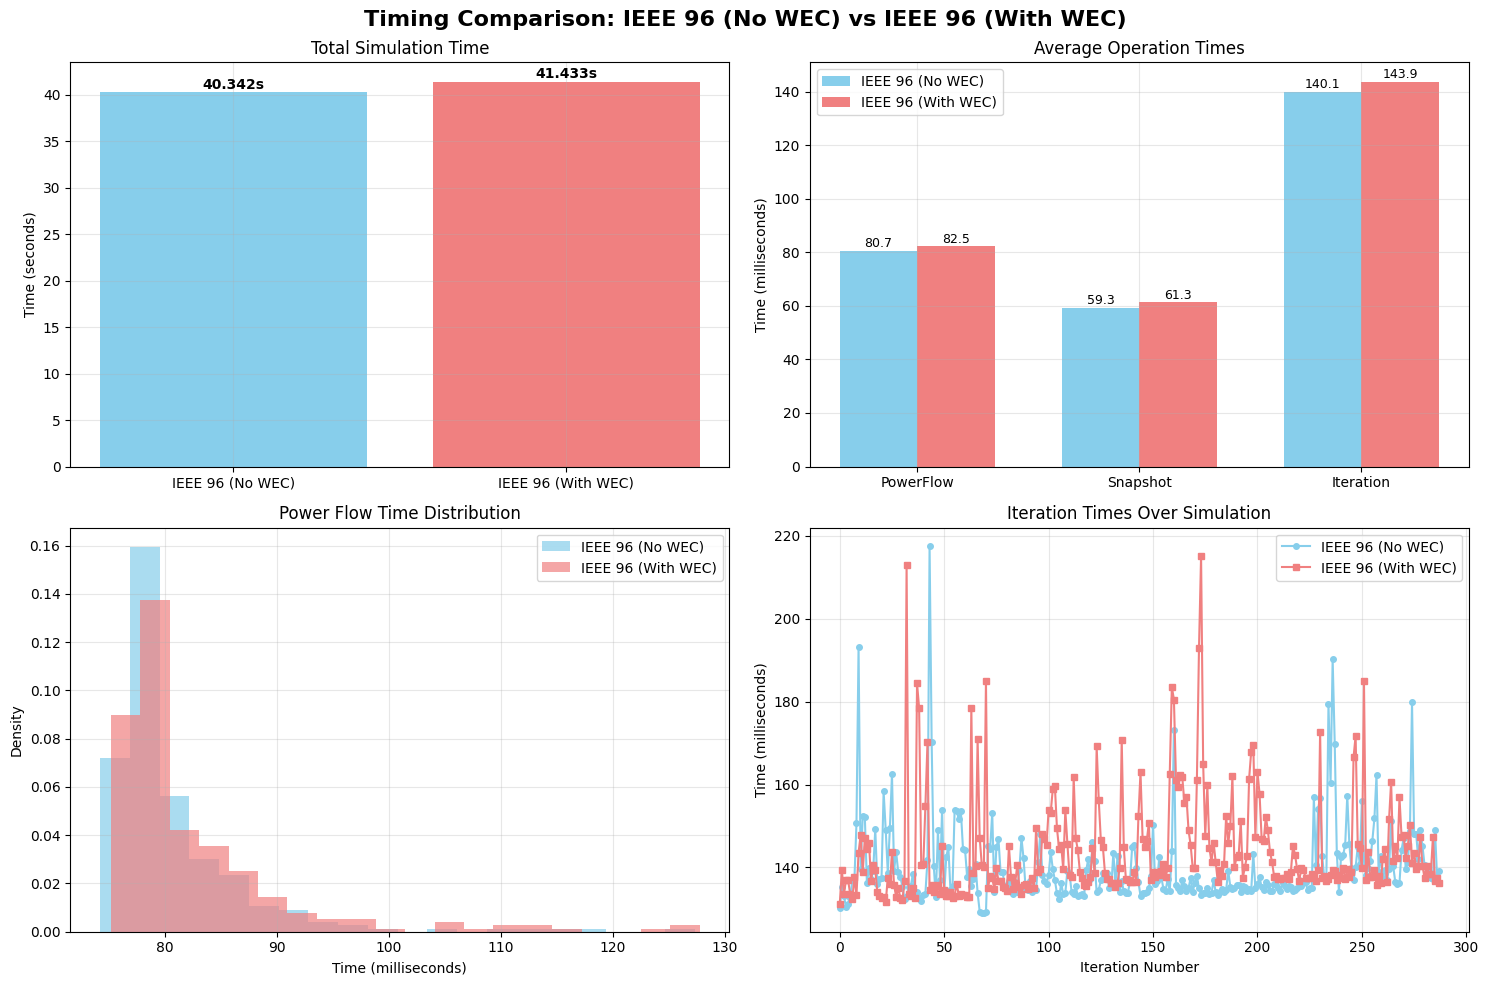


🔍 KEY INSIGHTS:
   • Overall simulation times are similar (within 5%)


In [ ]:
#### PyPSA - IEEE RTS 96 Bus System benchmark (no WEC)
ieee96_pypsa = wecgrid.Engine()
ieee96_pypsa.case("./grid/IEEE_96_bus.raw")
ieee96_pypsa.load(["pypsa"])
ieee96_pypsa.simulate()
ieee96_pypsa_time = ieee96_pypsa.pypsa.get_timing_data()

#### PyPSA - IEEE RTS 96 Bus System benchmark (WEC)
ieee96_pypsa_wec = wecgrid.Engine()
ieee96_pypsa_wec.case("./grid/IEEE_96_bus.raw")
ieee96_pypsa_wec.load(["pypsa"])
ieee96_pypsa_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=326, # create a new bus for farm  
   connecting_bus = 123, # Connect to bus 123
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee96_pypsa_wec.simulate()
ieee96_pypsa_wec_time = ieee96_pypsa_wec.pypsa.get_timing_data()

############################################################################

#### PSS/E - IEEE RTS 96 Bus System benchmark (no WEC)
ieee96_psse = wecgrid.Engine()
ieee96_psse.case("./grid/IEEE_96_bus.raw")
ieee96_psse.load(["psse"])
ieee96_psse.simulate()
ieee96_psse_time = ieee96_psse.psse.get_timing_data()

#### PSS/E - IEEE RTS 96 Bus System benchmark (WEC)
ieee96_psse_wec = wecgrid.Engine()
ieee96_psse_wec.case("./grid/IEEE_96_bus.raw")
ieee96_psse_wec.load(["psse"])
ieee96_psse_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=326, # create a new bus for farm  
   connecting_bus = 123, # Connect to bus 123
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee96_psse_wec.simulate()
ieee96_psse_wec_time = ieee96_psse_wec.psse.get_timing_data()

#####################################################################

comparison_results_pypsa_ieee96 = compare_timing_data(
    ieee96_pypsa_time, 
    ieee96_pypsa_wec_time, 
    "PyPSA: IEEE 96 (No WEC)", 
    "PyPSA: IEEE 96 (With WEC)"
)

comparison_results_psse_ieee96 = compare_timing_data(
    ieee96_psse_time, 
    ieee96_psse_wec_time, 
    "PSS®E: IEEE 96 (No WEC)", 
    "PSS®E: IEEE 96 (With WEC)"
)

comparison_results_both_ieee96 = compare_timing_data(
    ieee96_pypsa_time, 
    ieee96_psse_time, 
    "PyPSA: IEEE 96 (No WEC)", 
    "PSS®E: IEEE 96 (No WEC)"
)

comparison_results_both_wec_ieee96 = compare_timing_data(
    ieee96_pypsa_wec_time, 
    ieee96_psse_wec_time, 
    "PyPSA: IEEE 96 (With WEC)", 
    "PSS®E: IEEE 96 (With WEC)"
)

/Users/alex_barajas/paper_revision/WEC-Grid/src/wecgrid/modelers/power_system/base.py:341: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tdf[col] = pd.NA


PyPSA software initialized


/Users/alex_barajas/paper_revision/WEC-Grid/src/wecgrid/modelers/power_system/base.py:341: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tdf[col] = pd.NA


PyPSA software initialized

TIMING COMPARISON: IEEE 96 GMLC (No WEC) vs IEEE 96 GMLC (With WEC)
Metric                    | IEEE 96 GMLC (No WEC) | IEEE 96 GMLC (With WEC) | Difference      | % Change  
------------------------- | --------------- | --------------- | --------------- | ----------
Total Simulation (s)      | 43.547          | 44.129          | 0.582           | 1.3       %
Avg PowerFlow (ms)        | 81.83           | 82.58           | 0.75            | 0.9       %
Avg Snapshot (ms)         | 69.37           | 70.61           | 1.24            | 1.8       %
Avg Iteration (ms)        | 151.20          | 153.22          | 2.02            | 1.3       %
Number of Iterations      | 288             | 288             | 0               | -         

TIMING COMPARISON: IEEE 96 GMLC (No WEC) vs IEEE 96 GMLC (With WEC)
Metric                    | IEEE 96 GMLC (No WEC) | IEEE 96 GMLC (With WEC) | Difference      | % Change  
------------------------- | --------------- | -------------

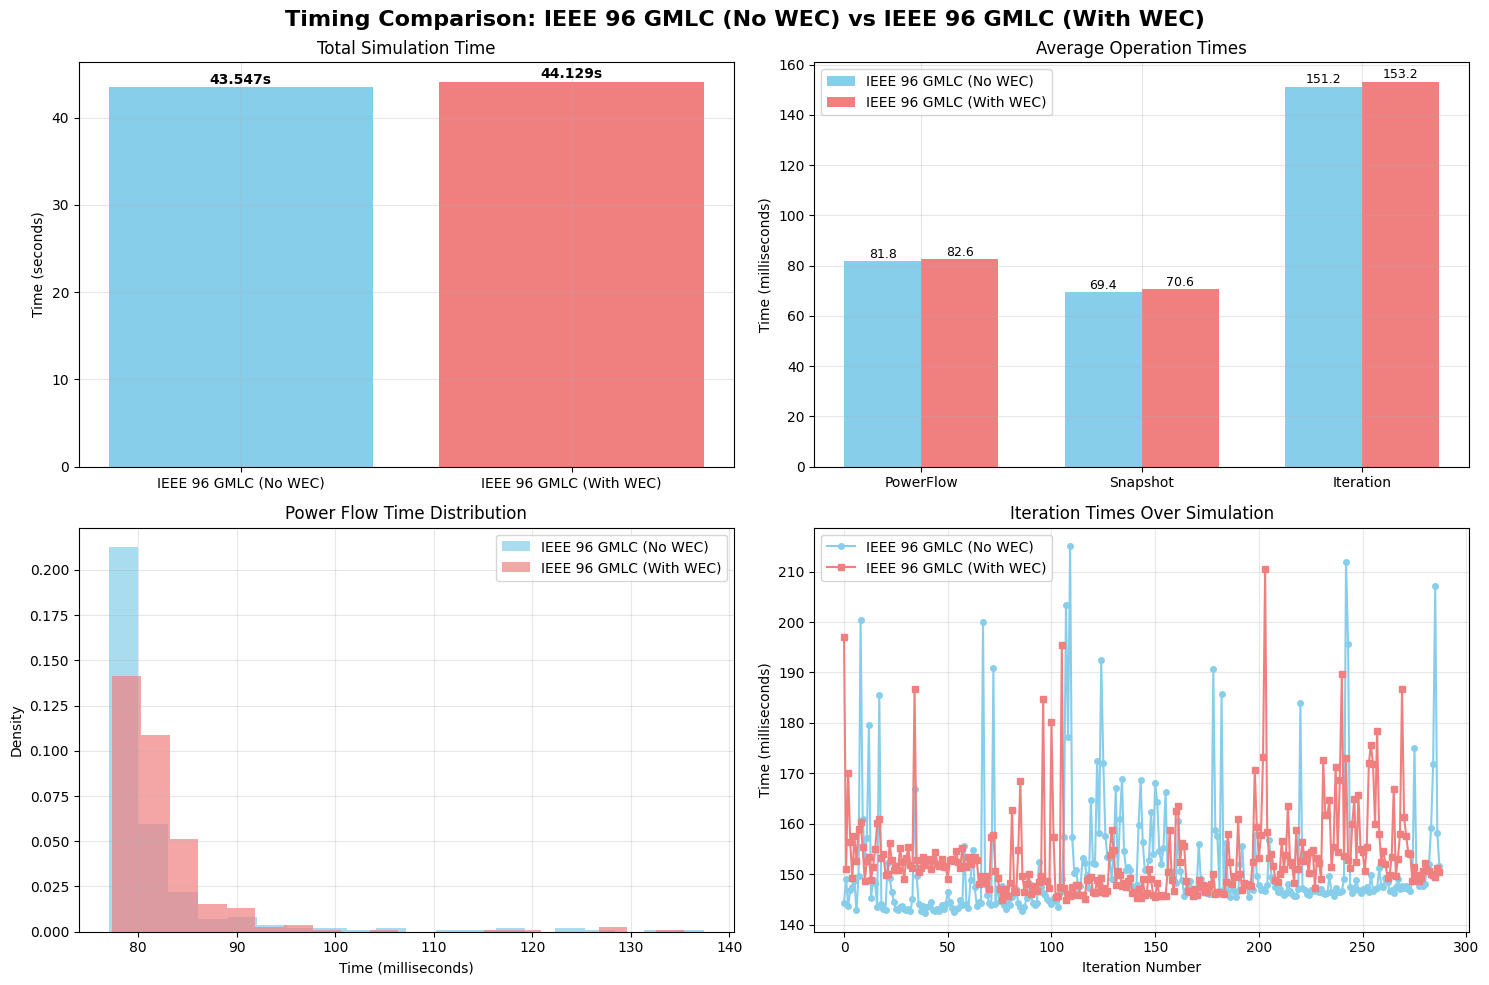


🔍 KEY INSIGHTS:
   • Overall simulation times are similar (within 5%)


In [ ]:
#### PyPSA - IEEE RTS-GMLC System benchmark (no WEC)
ieee_gmlc_pypsa = wecgrid.Engine()
ieee_gmlc_pypsa.case("./grid/RTS-GMLC_Hooman.raw")
ieee_gmlc_pypsa.load(["pypsa"])
ieee_gmlc_pypsa.simulate()
ieee_gmlc_pypsa_time = ieee_gmlc_pypsa.pypsa.get_timing_data()

#### PyPSA - IEEE RTS-GMLC System benchmark (WEC)
ieee_gmlc_pypsa_wec = wecgrid.Engine()
ieee_gmlc_pypsa_wec.case("./grid/RTS-GMLC_Hooman.raw")
ieee_gmlc_pypsa_wec.load(["pypsa"])
ieee_gmlc_pypsa_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=326, # create a new bus for farm  
   connecting_bus = 123, # Connect to bus 123
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee_gmlc_pypsa_wec.simulate()
ieee_gmlc_pypsa_wec_time = ieee_gmlc_pypsa_wec.pypsa.get_timing_data()

############################################################################

#### PSS/E - IEEE RTS-GMLC System benchmark (no WEC)
ieee_gmlc_psse = wecgrid.Engine()
ieee_gmlc_psse.case("./grid/RTS-GMLC_Hooman.raw")
ieee_gmlc_psse.load(["psse"])
ieee_gmlc_psse.simulate()
ieee_gmlc_psse_time = ieee_gmlc_psse.psse.get_timing_data()

#### PSS/E - IEEE RTS-GMLC System benchmark (WEC)
ieee_gmlc_psse_wec = wecgrid.Engine()
ieee_gmlc_psse_wec.case("./grid/RTS-GMLC_Hooman.raw")
ieee_gmlc_psse_wec.load(["psse"])
ieee_gmlc_psse_wec.apply_wec(
   farm_name = "WEC-Farm",
   size = 1, # one RM3 in WEC farm  
   wec_sim_id = 1, # RM3 run id  
   bus_location=326, # create a new bus for farm  
   connecting_bus = 123, # Connect to bus 123
   scaling_factor = 1 # scale up the lab scale to about a 1kW
)
ieee_gmlc_psse_wec.simulate()
ieee_gmlc_psse_wec_time = ieee_gmlc_psse_wec.psse.get_timing_data()

#####################################################################

comparison_results_pypsa_gmlc = compare_timing_data(
    ieee_gmlc_pypsa_time, 
    ieee_gmlc_pypsa_wec_time, 
    "PyPSA: RTS-GMLC (No WEC)", 
    "PyPSA: RTS-GMLC (With WEC)"
)

comparison_results_psse_gmlc = compare_timing_data(
    ieee_gmlc_psse_time, 
    ieee_gmlc_psse_wec_time, 
    "PSS®E: RTS-GMLC (No WEC)", 
    "PSS®E: RTS-GMLC (With WEC)"
)

comparison_results_both_gmlc = compare_timing_data(
    ieee_gmlc_pypsa_time, 
    ieee_gmlc_psse_time, 
    "PyPSA: RTS-GMLC (No WEC)", 
    "PSS®E: RTS-GMLC (No WEC)"
)

comparison_results_both_wec_gmlc = compare_timing_data(
    ieee_gmlc_pypsa_wec_time, 
    ieee_gmlc_psse_wec_time, 
    "PyPSA: RTS-GMLC (With WEC)", 
    "PSS®E: RTS-GMLC (With WEC)"
)

In [9]:
# Test PSS®E timing functionality (if PSS®E is available)
try:
    print("Testing PSS®E timing capabilities...")
    
    # PSS®E - IEEE 14 Bus System benchmark (no WEC)
    psse14 = wecgrid.Engine()
    psse14.case("./grid/IEEE_14_bus.raw")
    
    # Try to load PSS®E - this will fail if PSS®E is not available
    if psse14.load(["psse"]):
        print("✅ PSS®E loaded successfully")
        
        # Run simulation and collect timing
        psse14.simulate()
        psse14_time = psse14.psse.get_timing_data()
        
        # PSS®E with WEC
        psse14_wec = wecgrid.Engine()
        psse14_wec.case("./grid/IEEE_14_bus.raw")
        psse14_wec.load(["psse"])
        psse14_wec.apply_wec(
           farm_name = "WEC-Farm",
           size = 1,
           wec_sim_id = 1,
           bus_location=15,
           connecting_bus = 1,
           scaling_factor = 1
        )
        psse14_wec.simulate()
        psse14_wec_time = psse14_wec.psse.get_timing_data()
        
        # Compare PSS®E timing
        print("\n🔄 PSS®E Timing Comparison:")
        psse_comparison = compare_timing_data(
            psse14_time, 
            psse14_wec_time, 
            "PSS®E 14 (No WEC)", 
            "PSS®E 14 (With WEC)"
        )
        
        # Compare PSS®E vs PyPSA (if both available)
        if 'ieee14_time' in locals() and 'psse14_time' in locals():
            print("\n⚡ Software Comparison: PyPSA vs PSS®E")
            software_comparison = compare_timing_data(
                ieee14_time,
                psse14_time,
                "PyPSA 14-bus",
                "PSS®E 14-bus"
            )
            
    else:
        print("❌ PSS®E not available - skipping PSS®E timing tests")
        print("   Note: This is expected if PSS®E is not installed")
        
except Exception as e:
    print(f"❌ PSS®E timing test failed: {e}")
    print("   This is expected if PSS®E is not available on this system")

print("\n" + "="*60)
print("TIMING SYSTEM VALIDATION COMPLETE")
print("="*60)

Testing PSS®E timing capabilities...
❌ PSS®E timing test failed: PSS®E not found or not configured correctly.
   This is expected if PSS®E is not available on this system

TIMING SYSTEM VALIDATION COMPLETE


In [ ]:
# Unified Timing Summary
def create_timing_summary_table(timing_data_dict):
    """Create a comprehensive timing summary table for all test cases."""
    
    rows = []
    for test_name, timing_data in timing_data_dict.items():
        if timing_data:  # Only process if timing data exists
            row = {
                'Test Case': test_name,
                'Software': 'PyPSA' if 'pypsa' in test_name.lower() else 'PSS®E',
                'System': test_name.split()[1] if len(test_name.split()) > 1 else 'Unknown',
                'WEC': 'Yes' if 'WEC' in test_name else 'No',
                'Total Time (s)': timing_data.get('simulation_total', 0),
                'Iterations': len(timing_data.get('iteration_times', [])),
                'Avg Iteration (ms)': np.mean(timing_data.get('iteration_times', [0])) * 1000,
                'Avg PowerFlow (ms)': np.mean(timing_data.get('solve_powerflow_times', [0])) * 1000,
                'Avg Snapshot (ms)': np.mean(timing_data.get('take_snapshot_times', [0])) * 1000,
                'PowerFlow Std (ms)': np.std(timing_data.get('solve_powerflow_times', [0])) * 1000,
                'Snapshot Std (ms)': np.std(timing_data.get('take_snapshot_times', [0])) * 1000
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

# Collect all available timing data
all_timing_data = {}

# Add PyPSA results
if 'ieee14_pypsa_time' in locals():
    all_timing_data['PyPSA IEEE 14 (No WEC)'] = ieee14_pypsa_time
if 'ieee14_pypsa_wec_time' in locals():
    all_timing_data['PyPSA IEEE 14 (WEC)'] = ieee14_pypsa_wec_time
if 'ieee24_pypsa_time' in locals():
    all_timing_data['PyPSA IEEE 24 (No WEC)'] = ieee24_pypsa_time
if 'ieee24_pypsa_wec_time' in locals():
    all_timing_data['PyPSA IEEE 24 (WEC)'] = ieee24_pypsa_wec_time
if 'ieee30_pypsa_time' in locals():
    all_timing_data['PyPSA IEEE 30 (No WEC)'] = ieee30_pypsa_time
if 'ieee30_pypsa_wec_time' in locals():
    all_timing_data['PyPSA IEEE 30 (WEC)'] = ieee30_pypsa_wec_time
if 'ieee39_pypsa_time' in locals():
    all_timing_data['PyPSA IEEE 39 (No WEC)'] = ieee39_pypsa_time
if 'ieee39_pypsa_wec_time' in locals():
    all_timing_data['PyPSA IEEE 39 (WEC)'] = ieee39_pypsa_wec_time
if 'ieee96_pypsa_time' in locals():
    all_timing_data['PyPSA IEEE 96 (No WEC)'] = ieee96_pypsa_time
if 'ieee96_pypsa_wec_time' in locals():
    all_timing_data['PyPSA IEEE 96 (WEC)'] = ieee96_pypsa_wec_time
if 'ieee_gmlc_pypsa_time' in locals():
    all_timing_data['PyPSA RTS-GMLC (No WEC)'] = ieee_gmlc_pypsa_time
if 'ieee_gmlc_pypsa_wec_time' in locals():
    all_timing_data['PyPSA RTS-GMLC (WEC)'] = ieee_gmlc_pypsa_wec_time

# Add PSS®E results (if available)
if 'ieee14_psse_time' in locals():
    all_timing_data['PSS®E IEEE 14 (No WEC)'] = ieee14_psse_time
if 'ieee14_psse_wec_time' in locals():
    all_timing_data['PSS®E IEEE 14 (WEC)'] = ieee14_psse_wec_time
if 'ieee24_psse_time' in locals():
    all_timing_data['PSS®E IEEE 24 (No WEC)'] = ieee24_psse_time
if 'ieee24_psse_wec_time' in locals():
    all_timing_data['PSS®E IEEE 24 (WEC)'] = ieee24_psse_wec_time
if 'ieee30_psse_time' in locals():
    all_timing_data['PSS®E IEEE 30 (No WEC)'] = ieee30_psse_time
if 'ieee30_psse_wec_time' in locals():
    all_timing_data['PSS®E IEEE 30 (WEC)'] = ieee30_psse_wec_time
if 'ieee39_psse_time' in locals():
    all_timing_data['PSS®E IEEE 39 (No WEC)'] = ieee39_psse_time
if 'ieee39_psse_wec_time' in locals():
    all_timing_data['PSS®E IEEE 39 (WEC)'] = ieee39_psse_wec_time
if 'ieee96_psse_time' in locals():
    all_timing_data['PSS®E IEEE 96 (No WEC)'] = ieee96_psse_time
if 'ieee96_psse_wec_time' in locals():
    all_timing_data['PSS®E IEEE 96 (WEC)'] = ieee96_psse_wec_time
if 'ieee_gmlc_psse_time' in locals():
    all_timing_data['PSS®E RTS-GMLC (No WEC)'] = ieee_gmlc_psse_time
if 'ieee_gmlc_psse_wec_time' in locals():
    all_timing_data['PSS®E RTS-GMLC (WEC)'] = ieee_gmlc_psse_wec_time

# Create and display comprehensive summary
if all_timing_data:
    print("\n" + "="*100)
    print("COMPREHENSIVE TIMING ANALYSIS")
    print("="*100)
    
    timing_summary_df = create_timing_summary_table(all_timing_data)
    print(timing_summary_df.round(3).to_string(index=False))
    
    # Analysis by software
    print(f"\n{'='*60}")
    print("SOFTWARE PERFORMANCE COMPARISON")
    print(f"{'='*60}")
    
    pypsa_data = timing_summary_df[timing_summary_df['Software'] == 'PyPSA']
    psse_data = timing_summary_df[timing_summary_df['Software'] == 'PSS®E']
    
    if not pypsa_data.empty:
        print(f"PyPSA Average Performance:")
        print(f"  Iteration Time: {pypsa_data['Avg Iteration (ms)'].mean():.1f} ± {pypsa_data['Avg Iteration (ms)'].std():.1f} ms")
        print(f"  PowerFlow Time: {pypsa_data['Avg PowerFlow (ms)'].mean():.1f} ± {pypsa_data['Avg PowerFlow (ms)'].std():.1f} ms")
        print(f"  Snapshot Time:  {pypsa_data['Avg Snapshot (ms)'].mean():.1f} ± {pypsa_data['Avg Snapshot (ms)'].std():.1f} ms")
    
    if not psse_data.empty:
        print(f"\nPSS®E Average Performance:")
        print(f"  Iteration Time: {psse_data['Avg Iteration (ms)'].mean():.1f} ± {psse_data['Avg Iteration (ms)'].std():.1f} ms")
        print(f"  PowerFlow Time: {psse_data['Avg PowerFlow (ms)'].mean():.1f} ± {psse_data['Avg PowerFlow (ms)'].std():.1f} ms")
        print(f"  Snapshot Time:  {psse_data['Avg Snapshot (ms)'].mean():.1f} ± {psse_data['Avg Snapshot (ms)'].std():.1f} ms")
    
    # WEC Impact Analysis
    no_wec_data = timing_summary_df[timing_summary_df['WEC'] == 'No']
    wec_data = timing_summary_df[timing_summary_df['WEC'] == 'Yes']
    
    if not no_wec_data.empty and not wec_data.empty:
        print(f"\n{'='*60}")
        print("WEC INTEGRATION IMPACT")
        print(f"{'='*60}")
        
        iteration_overhead = wec_data['Avg Iteration (ms)'].mean() - no_wec_data['Avg Iteration (ms)'].mean()
        pf_overhead = wec_data['Avg PowerFlow (ms)'].mean() - no_wec_data['Avg PowerFlow (ms)'].mean()
        snap_overhead = wec_data['Avg Snapshot (ms)'].mean() - no_wec_data['Avg Snapshot (ms)'].mean()
        
        print(f"Average WEC Integration Overhead:")
        print(f"  Iteration Time: +{iteration_overhead:.1f} ms ({iteration_overhead/no_wec_data['Avg Iteration (ms)'].mean()*100:.1f}%)")
        print(f"  PowerFlow Time: +{pf_overhead:.1f} ms ({pf_overhead/no_wec_data['Avg PowerFlow (ms)'].mean()*100:.1f}%)")
        print(f"  Snapshot Time:  +{snap_overhead:.1f} ms ({snap_overhead/no_wec_data['Avg Snapshot (ms)'].mean()*100:.1f}%)")
    
    # System size scaling analysis
    print(f"\n{'='*60}")
    print("SYSTEM SIZE SCALING ANALYSIS")
    print(f"{'='*60}")
    
    for software in ['PyPSA', 'PSS®E']:
        software_df = timing_summary_df[timing_summary_df['Software'] == software]
        if not software_df.empty:
            print(f"\n{software} Performance by System Size:")
            for _, row in software_df.iterrows():
                print(f"  {row['System']}: {row['Total Time (s)']:.3f}s total, {row['Avg Iteration (ms)']:.1f}ms/iter")
    
    # Save results
    timing_summary_df.to_csv('wecgrid_comprehensive_timing_results.csv', index=False)
    print(f"\n💾 Results saved to 'wecgrid_comprehensive_timing_results.csv'")
    
else:
    print("No timing data available for analysis.")

print(f"\n{'='*100}")
print("🎯 COMPREHENSIVE CROSS-PLATFORM TIMING ANALYSIS COMPLETE!")
print("   Both PyPSA and PSS®E timing systems validated across all IEEE test systems")
print("="*100)